<a href="https://colab.research.google.com/github/karlbuscheck/modular-transfer-learning-pipeline/blob/main/modular_transfer_learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modular Pipeline for Transfer Learning With Pretrained Computer Vision Models**

### **Project Overview**

In this notebook, we build a modular deep learning pipeline for transfer learning with pretrained computer vision models in [Keras Applications](https://keras.io/api/applications/). This notebook features the workflow for utilizing `VGG16`, a deep convolutional neural network with 16 layers -- [a classic architecture](https://keras.io/api/applications/vgg/) for image recognition tasks. But what makes the pipeline powerful is that it can easily be adapted for any of the commonly used models in Keras.

Here's the plan we'll follow:
- Load and prepare the data
- Customize and train `VGG16`
- Evaluate the model's performance
- Visualize the predictions
- Deploy the pipeline

### **Tools & Libraries Used**
- **Google Colab** — for GPU access and seamless notebook execution
- **Python 3.12.12** — base language for all model building
- **TensorFlow/Keras** — for model building and training
- **NumPy** — for numerical operations and array manipulation
- **Pandas** — for managing and inspecting data structures
- **Matplotlib (PyPlot)** — for visualizing training performance and model predictions

### **Acknowledgments**:

Before diving in, it's important to note that this project was inspired by a lecture notebook in Mohammad Amin Morid's Deep Learning class at the Leavey School of Business at Santa Clara University. Morid is an Assistant Professor at the school's Information Systems & Analytics department.

##**Load and prepare the data**

In [ ]:
# Start with the imports
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd

We'll evaluate our modular transfer learning pipeline on CIFAR-10, one of the most popular benchmark datasets in computer vision. The dataset consists of 60,000 32x32 color images split across 10 object classes, with 6000 images per class. To learn more about the dataset, follow this [link](https://www.kaggle.com/c/cifar-10).

The labels are as follows:

- airplane (0)
- automobile (1)
- bird (2)
- cat (3)
- deer (4)
- dog (5)
- frog (6)
- horse (7)
- ship (8)
- truck (9)

Let's begin by loading the dataset and splitting it into training and test sets.

In [ ]:
# Load the CIFAR-10 dataset from Keras and split into full training and test sets
cifar = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar.load_data()

# Display the shape of the training and test sets -- specificaly the actual images,
# not the labels
# Note: This output shows us that there are 50K images in the training set
# and 10K in the test set and that each image is 32x32 with three channels (the RGB colors)
print(X_train_full.shape)
print(X_test_full.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Next, we'll visualize the first few images from the training set with the help of a simple for loop.

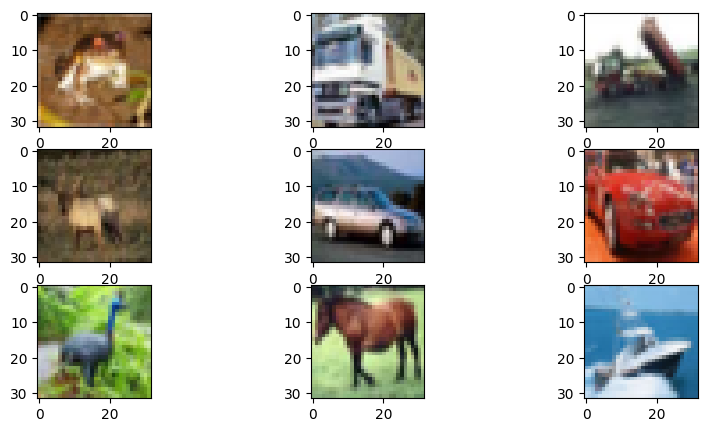

In [ ]:
# Write a for loop to display the first 9 image
# in a 3x3 grid
from matplotlib import pyplot
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(X_train_full[i])
pyplot.rcParams["figure.figsize"] = (10,5)
pyplot.show()

Use the `.to_categorical()` function to one-hot encode all the labels and then map them back to the class names for improved interpetability.

In [ ]:
# Use .to_categorical() to one-hot encode the labels in the training and test sets into
# 0's and 1's
y_train_categorical = keras.utils.to_categorical(y_train_full, 10)
y_test_categorical = keras.utils.to_categorical(y_test_full, 10)

# Display the one-hot encoded labels for the first instance in the training set
# Note: The 1 in the seventh position tells us it's a 7 or a frog, as we can confrim
# in the visualization above
print(y_train_categorical[0])

# Just for fun, map the lables to the class names
# Note: Remember that argmax just returns the index of the maximum value (the only 1!)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Class name:', class_names[np.argmax(y_train_categorical[0])])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Class name: frog


As a final step before diving into the model building process, split the full training sets into validation and training sets.

In [ ]:
# Split the full training sets into validation and trainging sets
# of 5K and 45K images, respectively
# Note: The test set, of course, doesn't need to be split so it remains as is
X_valid, X_train, X_test = X_train_full[:5000], X_train_full[5000:], X_test_full
y_valid, y_train = y_train_categorical[:5000], y_train_categorical[5000:]

# Display the shape of X_train, X_valid and X_test to ensure the splits were executed properly
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

# Just for fun, let's print the shape of y_train, y_valid and y_test_categorical, too
print(y_train.shape)
print(y_valid.shape)
print(y_test_categorical.shape)

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(10000, 32, 32, 3)
(45000, 10)
(5000, 10)
(10000, 10)


## **Customize and train `VGG16`**

Now, to "build" our pretrained model, `VGG16`, a simple and classic CNN architecture with 16 layers -- 13 convolutional layers followed by 3 fully connected (dense) layers. Read all about it right here in the offical [Keras documentation](https://keras.io/api/applications/vgg/). It was trained on ImageNet, which consists of **over 14 million images**.

In [ ]:
# Import models, applications and layers
# Note: Applications is what provides us access to pretrained models like VGG16
from keras import models, applications, layers

# Initilaize the pretrained model, VGG16
# Note: This model summary will show the 13 convolutional layers + 1 input layer + 5 pooling layers
# but not the 3 dense layers because we set 'include_top=False'
pretrained_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))


# Freeze all the layers in the pretrained model
# Note: This keeps the pretrained ImageNet weights fixed for feature extraction
pretrained_model.trainable = False

# Optional: Example code for fine-tuning -- this approach unfreezes
# only the last five layers for retraining
#for layer in pretrained_model.layers[:-5]: #Fine-tunning
#            pretrained_model.trainable = False

# Display the model summary
# Important note: There are 0 trainable parameters because we froze
# all the deep learning layers as part of the feature extraction process
pretrained_model.summary()


# Now, initilaize and start building the customized classifier that will be
# built on top of the VGG16 pretrained model
# Essentially, we removed the built-in final 3 layers and replaced them with a custom
# 6-layer classification head
model = models.Sequential()

# Note: This is the important line of code where we merge the pretrained model
# with the custom model we are about to build
model.add(pretrained_model)

# Add a flatten layer to collapse the 1×1×512 feature map into a 512-dimensional vector
model.add(layers.Flatten())

# Add a dense layer to learn higher-level feature combinations with relu as the activation function
model.add(layers.Dense(512, activation=('relu')))

# Add dropout to reduce overfitting
model.add(layers.Dropout(0.2))

# Add a dense layer to refine learned features with fewer parameters; Again, relu as the activation function
model.add(layers.Dense(256, activation=('relu')))

# Add another round of dropout
model.add(layers.Dropout(0.2))

# Add a dense layer that outputs probabilities for each of the 10 classes using softmax
model.add(layers.Dense(10, activation=('softmax')))

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

What we see above is just the pretrained `VGG16` model -- less the final three layers that were removed. Below, we'll show the summary of the *actual* model -- the pretrained base + plus the custom 6-layer add on. Check that out... **over 15.1M parameters... sort of!** But, crucially, only about 400K are trainable because all the parameters from the pretrained model were frozen.

In [ ]:
# Print the summary of the custom model that we just built -- pretrained VGG16 model
# with the customized classifier
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,111,242 (57.64 MB)

 Trainable params: 396,554 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Up next, some critical preprocessing to make the input images from CIFAR-10 compatible with `VGG16`'s expectations. Since the pretrained model was trained on ImageNet, the new input images must be preprocessed the same way, or else the model’s learned weights won’t interpret them correctly.

In [ ]:
# Use .preprocess_input to rescale, recenter, and reorder channels
# to match how VGG16 was trained on ImageNet
x_train = keras.applications.vgg16.preprocess_input(X_train)
x_valid = keras.applications.vgg16.preprocess_input(X_valid)
x_test = keras.applications.vgg16.preprocess_input(X_test)

Pretty remarkable how *modular* those above lines of code are. Had we been using `ResNet` or `MobileNet` or `InceptionV3`, we would have simply dropped in one of those model names instead. And now, to start training.

In [ ]:
# Initialize the Adam optimizer with a small, stable  learning rate for smooth training of the new top layers
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Compile the model with Adam as the optimizer, categorical cross entropy as the
# loss function and accuracy as the metric
model.compile(optimizer=optimizer,  loss='categorical_crossentropy',  metrics=['accuracy'])

# Then train or fit the model on the training set; We'll run 5 epochs with a batch size of 512 instances,
# and, of course, use x_valid and y_valid -- split off from the full training set -- as the validation sets
trained_model = model.fit(x_train, y_train, epochs=5, batch_size=512, validation_data=(x_valid, y_valid))

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.3708 - loss: 5.0447 - val_accuracy: 0.5620 - val_loss: 1.2668
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.5534 - loss: 1.3098 - val_accuracy: 0.6116 - val_loss: 1.1245
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.6066 - loss: 1.1239 - val_accuracy: 0.6330 - val_loss: 1.0614
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.6423 - loss: 1.0214 - val_accuracy: 0.6448 - val_loss: 1.0202
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.6696 - loss: 0.9417 - val_accuracy: 0.6590 - val_loss: 1.0002


**Initial takeaway**: With just five epochs of training, the model reaches 65% validation accuracy, not bad for our first run at transfer learning with this customized `VGG16` model. Further fine-tuning, longer training, data augmentation or even an entirely different pretrained model could take this performance to the next level.

Next, let's visualize the accuracies and losses on a single plot.

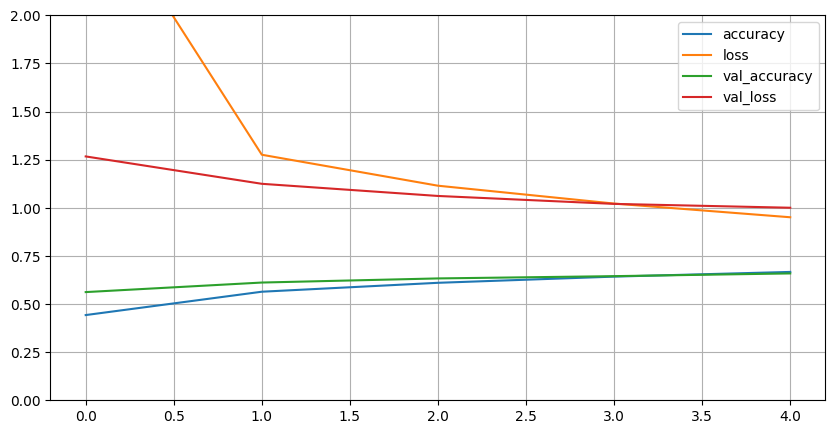

In [ ]:
# Create a DataFrame of the trained_model.history object that records all the
# accuracies and losses from all the epochs
pd.DataFrame(trained_model.history).plot(figsize=(10, 5))
pyplot.grid(True)
pyplot.gca().set_ylim(0, 2)
pyplot.show()

This plot shows that both the accuracy and validation accuracy are flatteing and the loss and validation loss are both plateauing, indicating that this current model architecture has reached its peak performance.

## **Evaluate the model's performance**

Let's evaluate the model on the test set to see how this customized `VGG16` generalizes to unseen data.

In [ ]:
# Evaluate the model on the test set
model.evaluate(x_test, y_test_categorical)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6525 - loss: 1.0196


[1.0155361890792847, 0.6534000039100647]

The test accuracy and loss are both exactly in line with what we saw on the validation set, showing that the model generalizes well to unseen data, but the overall performance remains quite low, as we'd expect. Next, we'll take a look under the hood to view the raw prediction probabilites for the test set.

In [ ]:
# Generate the predicted class probabilites on the test set
y_pred = model.predict(X_test)

# Round to 3 decimal places for improved readability
y_pred.round(3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


array([[0.008, 0.   , 0.079, ..., 0.008, 0.002, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.999, 0.   ],
       [0.051, 0.004, 0.002, ..., 0.   , 0.932, 0.009],
       ...,
       [0.013, 0.001, 0.149, ..., 0.012, 0.016, 0.002],
       [0.612, 0.   , 0.375, ..., 0.   , 0.   , 0.   ],
       [0.017, 0.006, 0.129, ..., 0.697, 0.006, 0.007]], dtype=float32)

Next, we'll turn each of those probabilites into class numbers. So, in the output below, 3 meant that class 3 had the highest probability.

In [ ]:
# Now, turn the predicted probabilities into discrete class lables using
# argmax, which returns the index of the highest probability -- aka the predicted class
# Note: By specifying axis=1, we find the max value row-wise
y_pred_class= np.argmax(y_pred,axis=1)
y_pred_class

array([3, 8, 8, ..., 5, 0, 7])

And just for fun, let's see what those class numbers map to...

In [ ]:
# OPTIONAL: Since we already created the 'class_names' as a list variable of all the classes,
# let's map the predicted class indices to their corresponding labels
y_pred_labels = [class_names[i] for i in y_pred_class]

# Display the first 10 predictions for reference
print(y_pred_labels[:10])

['cat', 'ship', 'ship', 'ship', 'bird', 'airplane', 'airplane', 'frog', 'cat', 'cat']


## **Visualize the predictions**

To wrap up, we'll visualize where the model got the predictions right and where it got them wrong.

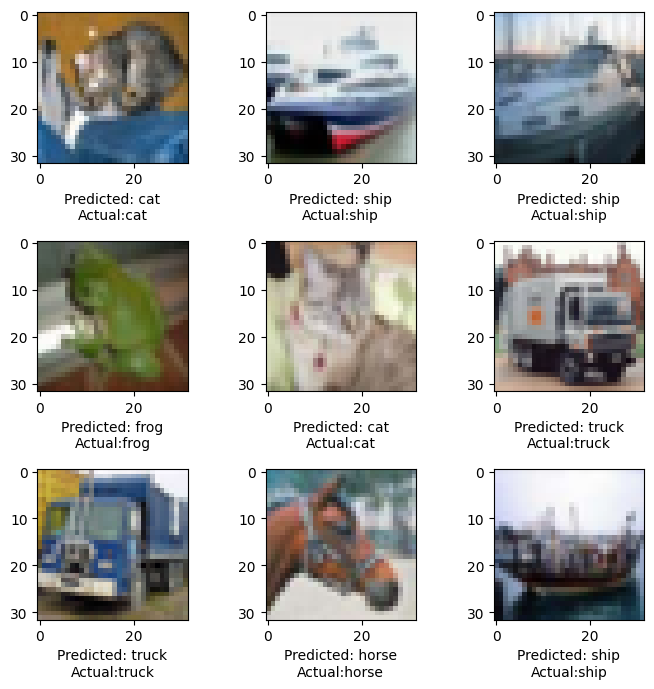

In [ ]:
# Start by visualizing the first 9 images where the model got it right
# Create a 3x3 grid, showing where the model's predictions match the actual labels
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

errorCnt = 9
tCnt = 0
index  = 0

fig, axes = pyplot.subplots(3, 3, figsize=(7,7))
fig.subplots_adjust(hspace=0.6, wspace=0.6)

while tCnt < errorCnt and index < len(y_pred_class):
  if y_pred_class[index] == y_test_full[index]:
    axes.flat[tCnt].imshow(X_test_full[index])
    axes.flat[tCnt].set_xlabel("Predicted: " + class_names[y_pred_class[index]] + "\nActual:"  + class_names[y_test_full[index][0]])
    tCnt+=1
  index+=1

pyplot.tight_layout()
pyplot.show()

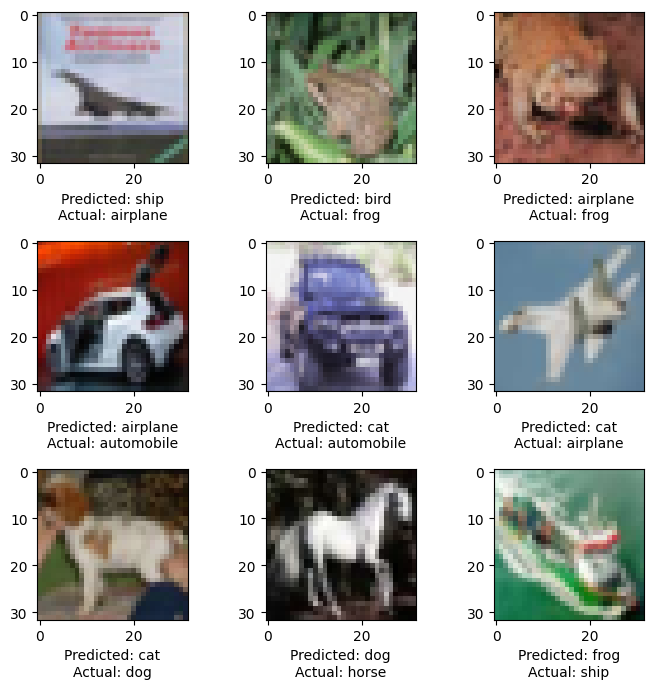

In [ ]:
# Create a 3x3 grid of test images to visually inspect the model's predictions,
# specifically highligting where it got it wrong
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

errorCnt = 9
tCnt = 0
index  = 0

fig, axes = pyplot.subplots(3, 3, figsize=(7,7))
fig.subplots_adjust(hspace=0.6, wspace=0.6)

while tCnt < errorCnt and index < len(y_pred_class):
  if y_pred_class[index] != y_test_full[index]:
    axes.flat[tCnt].imshow(X_test_full[index])
    axes.flat[tCnt].set_xlabel("Predicted: " + class_names[y_pred_class[index]] + "\nActual: "  + class_names[y_test_full[index][0]])
    tCnt+=1
  index+=1

pyplot.tight_layout()
pyplot.show()

## **Deploy the pipeline**

Our customized `VGG16` hit a respectable 65% accuracy -- a solid first step in transfer learning. But, the model performance isn't really the point here, at leasy not yet.

Now, we have a clean, modular pipeline running pretrained models like `MobileNet`, `InceptionV3` and `ResNet`. Up next, we'll see how far these architectures can take us with CIFAR-10 and computer vision tasks far beyond.